# 고객 행동 예측
* 군집화

## 1. 데이터 확인

In [1]:
import pandas as pd

uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [2]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## 2. 군집화를 통한 회원 그룹화

In [3]:
customer_clustering = customer[['mean','median','max','min','membership_period']]
customer_clustering.head()

mean  median  max  min  membership_period
0  4.833333     5.0    8    2                 47
1  5.083333     5.0    7    3                 47
2  4.583333     5.0    6    3                 47
3  4.833333     4.5    7    2                 47
4  3.916667     4.0    6    1                 47

* 'mean','median','max','min','membership_period'의 각 데이터 크기 차이가 크므로 표준화가 필요함

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[3 1 0 2]


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


mean  median  max  min  membership_period  cluster
0  4.833333     5.0    8    2                 47        3
1  5.083333     5.0    7    3                 47        3
2  4.583333     5.0    6    3                 47        3
3  4.833333     4.5    7    2                 47        3
4  3.916667     4.0    6    1                 47        3

## 3. 군집화 결과 분석

In [5]:
customer_clustering.columns = ['월평균값','월중앙값','월최대값','월최소값','회원기간','cluster']
customer_clustering.groupby('cluster').count()

월평균값  월중앙값  월최대값  월최소값  회원기간
cluster                              
0        1334  1334  1334  1334  1334
1         763   763   763   763   763
2         846   846   846   846   846
3        1249  1249  1249  1249  1249

In [6]:
customer_clustering.groupby('cluster').mean()

월평균값      월중앙값       월최대값      월최소값       회원기간
cluster                                                    
0        5.524239  5.375187   8.745877  2.687406  14.843328
1        3.054713  2.888598   4.756225  1.653997   9.263434
2        8.054608  8.039598  10.009456  6.160757   7.072104
3        4.677494  4.671337   7.232986  2.153723  36.915933

## 4. 시각화
* 주성분분석

In [7]:
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

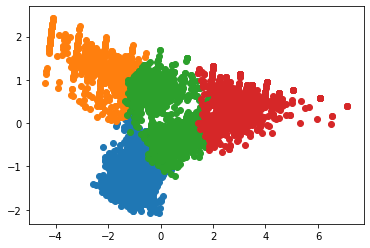

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0], tmp[1])

## 5. 군집화 결과로 탈퇴 회원의 경향 파악
* is_deleted열을 customer_clustering에 추가, cluster 및 is_deleted별로 집계

In [9]:
customer_clustering.head()

월평균값  월중앙값  월최대값  월최소값  회원기간  cluster
0  4.833333   5.0     8     2    47        3
1  5.083333   5.0     7     3    47        3
2  4.583333   5.0     6     3    47        3
3  4.833333   4.5     7     2    47        3
4  3.916667   4.0     6     1    47        3

In [10]:
customer.head()

customer_id   name class gender  start_date end_date campaign_id  \
0    OA832399   XXXX   C01      F  2015-05-01      NaN         CA1   
1    PL270116  XXXXX   C01      M  2015-05-01      NaN         CA1   
2    OA974876  XXXXX   C01      M  2015-05-01      NaN         CA1   
3    HD024127  XXXXX   C01      F  2015-05-01      NaN         CA1   
4    HD661448  XXXXX   C03      F  2015-05-01      NaN         CA1   

   is_deleted class_name  price campaign_name      mean  median  max  min  \
0           0       0_종일  10500          2_일반  4.833333     5.0    8    2   
1           0       0_종일  10500          2_일반  5.083333     5.0    7    3   
2           0       0_종일  10500          2_일반  4.583333     5.0    6    3   
3           0       0_종일  10500          2_일반  4.833333     4.5    7    2   
4           0       2_야간   6000          2_일반  3.916667     4.0    6    1   

   routine_flg   calc_date  membership_period  
0            1  2019-04-30                 47  
1            1  2019-04-30                 47  
2            1  2019-04-30                 47  
3            1  2019-04-30                 47  
4            1  2019-04-30                 47

In [11]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted','customer_id']]

cluster  is_deleted  customer_id
0        0           0          785
1        0           1          549
2        1           1          763
3        2           0          827
4        2           1           19
5        3           0         1230
6        3           1           19

In [12]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg','customer_id']]

cluster  routine_flg  customer_id
0        0            0          228
1        0            1         1106
2        1            0          497
3        1            1          266
4        2            0           52
5        2            1          794
6        3            0            2
7        3            1         1247

## 6. 다음 달의 이용 횟수 예측을 위한 데이터 준비
### A. uselog 데이터를 이용해 연월, 회원마다 집계

In [13]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id' : 'count'}, inplace=True)

del uselog_months['usedate']
uselog_months.head()

연월 customer_id  count
0  201804    AS002855      4
1  201804    AS009013      2
2  201804    AS009373      3
3  201804    AS015315      6
4  201804    AS015739      7

### B. 2018년 10월부터 2019년 3월까지 과거 5개월분 이용횟수와 다음달의 이용횟수 저장

In [15]:
year_months = list(uselog_months['연월'].unique()) # 201804 ~ 201903
predict_data = pd.DataFrame()

for i in range(6, len(year_months)): # 201810 ~ 201903
    tmp = uselog_months.loc[uselog_months['연월']==year_months[i]]
    tmp.rename(columns={'count' : 'count_pred'}, inplace=True)
    for j in range(1,7):
        tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-j]]
        del tmp_before['연월']
        tmp_before.rename(columns={'count' : 'count_{}'.format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS008805           2      2.0      5.0      7.0      8.0   
2  201810    AS009373           5      6.0      6.0      7.0      4.0   
3  201810    AS015233           7      9.0     11.0      5.0      7.0   
4  201810    AS015315           4      7.0      3.0      6.0      3.0   

   count_4  count_5  
0      5.0      4.0  
1      NaN      NaN  
2      4.0      3.0  
3      7.0      NaN  
4      3.0      6.0

In [16]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  
0      5.0      4.0  
1      4.0      3.0  
2      3.0      6.0  
3      5.0      7.0  
4      8.0      6.0

## 7. 독립변수 추가

In [17]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on='customer_id', how='left')
predict_data.head()

연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5  start_date  
0      5.0      4.0  2016-11-01  
1      4.0      3.0  2015-11-01  
2      3.0      6.0  2015-07-01  
3      5.0      7.0  2017-06-01  
4      8.0      6.0  2017-10-01

In [21]:
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format='%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

from dateutil.relativedelta import relativedelta

predict_data['period'] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
    predict_data['period'][i] = delta.years*12 + delta.months
predict_data.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


연월 customer_id  count_pred  count_0  count_1  count_2  count_3  \
0  201810    AS002855           3      7.0      3.0      5.0      5.0   
1  201810    AS009373           5      6.0      6.0      7.0      4.0   
2  201810    AS015315           4      7.0      3.0      6.0      3.0   
3  201810    AS015739           5      6.0      5.0      8.0      6.0   
4  201810    AS019860           7      5.0      7.0      4.0      6.0   

   count_4  count_5 start_date   now_date period  
0      5.0      4.0 2016-11-01 2018-10-01     23  
1      4.0      3.0 2015-11-01 2018-10-01     35  
2      3.0      6.0 2015-07-01 2018-10-01     39  
3      5.0      7.0 2017-06-01 2018-10-01     16  
4      8.0      6.0 2017-10-01 2018-10-01     12

## 8. 회귀 모델

In [22]:
from sklearn import linear_model
import sklearn.model_selection

predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

model = linear_model.LinearRegression()
X = predict_data[['count_0','count_1','count_2','count_3','count_4','count_5','period']]
y = predict_data['count_pred']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6028092457092975
0.6225218765461253


## 9. 독립변수별 계수 확인

In [25]:
coef = pd.DataFrame({'feature_names' : X.columns, 'coefficient' : model.coef_})
coef

feature_names  coefficient
0       count_0     0.328388
1       count_1     0.186886
2       count_2     0.187746
3       count_3     0.181768
4       count_4     0.058669
5       count_5     0.075501
6        period     0.089578

## 10. 다음 달의 이용 횟수 예측

In [26]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1, x2]

model.predict(x_pred)

array([3.82796182, 2.0825743 ])